In [1]:
import numpy as np
"""from google.colab import drive
drive.mount('/content/drive')
!ls drive/'My Drive/YYY_deep_project_YYY'"""


"from google.colab import drive\ndrive.mount('/content/drive')\n!ls drive/'My Drive/YYY_deep_project_YYY'"

In [2]:
#%cd drive/'My Drive/YYY_deep_project_YYY'

In [3]:
def get_sequence(infile):

    while True:

        header = infile.readline()
        sequence = infile.readline()

        pdb = header[1:5]

        if not header or not sequence or set(sequence) == {'X'}:
            return
        
        yield header.strip()[1:], sequence.strip(), pdb

4687


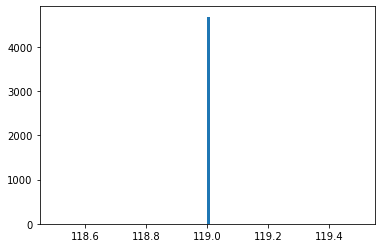

In [4]:
sequences = []
seq_to_pdb = {}
count = 0
with open('data/sra100k_done.fa') as infile:
#with open('data/all_heavy.fasta') as infile:
        for header, sequence, pdb in get_sequence(infile):
            sequences.append(list(sequence))
            seq_to_pdb[sequence] = pdb

#sequences = list(filter(lambda x:len(x)<150, sequences))

import random

slen = 120
sequences = [seq for seq in sequences if len(seq) == slen-1]

random.shuffle(sequences)

sequences = sequences[:8000]

import matplotlib.pyplot as plt
lengths = [len(seq) for seq in sequences]

print(len(sequences))

plt.hist(lengths, bins=100)
plt.show()


In [5]:
from torch.utils import data
from random import shuffle


class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    
    
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)
    
    print(num_train, num_val, num_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]

    # add reversed sequences for training and shuffle
    #sequences_train += [seq[::-1] for seq in sequences_train]
    #shuffle(sequences_train)

    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[num_train+num_val:]

    input_train = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_train]
    input_val = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_val]
    input_test = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_test]

    return (input_train, input_val, input_test)

(input_train, input_val, input_test) = create_datasets(sequences, Dataset)

len(input_train), len(input_val), len(input_test)

3749 468 468


(3749, 468, 470)

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
        
        self.model_type = 'Transformer'
        
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        
        self.t_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        self.embed = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        
        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        
        self.t_decoder = TransformerDecoder(decoder_layers, nlayers)

        
        self.ff = nn.Linear(ninp, ntoken)
        
        self._init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float(-1e-10)).masked_fill(mask == 1, float(0.0))
        
        return mask

 
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
       

    def forward(self, src, src_mask, tgt, tgt_mask, src_pad_mask, tgt_pad_mask, mem_pad_mask=None):
        

        embeds = self.embed(src) * math.sqrt(self.ninp)
        
        positions = self.pos_encoder(embeds)
    
        
        encoded = self.t_encoder(positions)
        #encoded = self.t_encoder(positions, src_key_padding_mask=src_pad_mask)
        
        
        if mem_pad_mask is None:
            mem_pad_mask = tgt_pad_mask.clone()
            
        embeds = self.embed(tgt) * math.sqrt(self.ninp)
        
        positions = self.pos_encoder(embeds)
        

        decoded = self.t_decoder(tgt=positions, memory=encoded, tgt_mask=tgt_mask)
  
        output = self.ff(decoded)

        return output




In [7]:
    
vocab = ['<pad>', "<sos>", "<eos>"] + ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","X","Y"]
char_nums = {token:vocab.index(token) for token in vocab}


def batchify(data):
    
    # get the length of each seq in your batch
    seq_lengths = torch.LongTensor([len(seq) for seq in data])

    train_vectorized = [[char_nums[char] for char in seq] for seq in data]
    sources = [seq[:-1] for seq in train_vectorized]
    targets = [seq[1:] for seq in train_vectorized]
    
    # dump padding everywhere, and place seqs on the left.
    # NOTE: you only need a tensor as big as your longest sequence
    src_tensor = torch.zeros((len(train_vectorized), seq_lengths.max()-1)).long()
    tgt_tensor = torch.zeros((len(train_vectorized), seq_lengths.max()-1)).long()

    
    for idx, (seq, seqlen) in enumerate(zip(sources, seq_lengths)):
        src_tensor[idx, :(seqlen-1)] = torch.LongTensor(seq)
    
    for idx, (seq, seqlen) in enumerate(zip(targets, seq_lengths)):
        tgt_tensor[idx, :(seqlen-1)] = torch.LongTensor(seq)
        
        
    # SORT YOUR TENSORS BY LENGTH!
    seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    
    src_tensor = src_tensor[perm_idx]
    tgt_tensor = tgt_tensor[perm_idx]

    return src_tensor, tgt_tensor


train_src, train_tgt = batchify(input_train)
val_src, val_tgt = batchify(input_val)
test_src, test_tgt = batchify(input_test)

train_src.shape

torch.Size([3749, 120])

In [8]:
bptt = 100

def get_batch(sources, targets, i):
    n_seqs = min(bptt, len(sources) - 1 - i)
    
    max_len = max([len(seq) for seq in sources])
    
    src = torch.cat([sources[i] for i in range(n_seqs)]).view(n_seqs,max_len)
        
    target = torch.cat([targets[i] for i in range(n_seqs)]).view(n_seqs,max_len)#.reshape(-1)
    
    return src, target



In [9]:
ntokens = len(vocab) # the size of vocabulary
nhid = slen
nhead = 8
emsize = slen
nlayers = 6
dropout = 0 # the dropout value

emsize, nhid

(120, 120)

In [10]:
train_src, train_tgt


(tensor([[ 1,  8,  6,  ...,  6, 14, 18],
         [ 1,  8,  6,  ...,  6, 14, 18],
         [ 1,  3, 18,  ...,  6, 14, 18],
         ...,
         [ 1,  3, 18,  ...,  6, 14, 18],
         [ 1,  8,  6,  ...,  6, 14, 18],
         [ 1,  3, 18,  ..., 10, 18,  8]]),
 tensor([[ 8,  6, 18,  ..., 14, 18,  2],
         [ 8,  6, 18,  ..., 14, 18,  2],
         [ 3, 18, 20,  ..., 14, 18,  2],
         ...,
         [ 3, 18, 20,  ..., 14, 18,  2],
         [ 8,  6, 18,  ..., 14, 18,  2],
         [ 3, 18, 20,  ..., 18,  8,  2]]))

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
#criterion = nn.CrossEntropyLoss()

lr = 0.1 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer  = torch.optim.Adam(lr=lr, params=model.parameters())

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.995)

train_losses = []
val_losses = []
model.to(device)
import sys
import time
def train():
    
    train_loss = 0
    n_batches = 0
    
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(vocab)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    for batch, i in enumerate(range(0, train_src.size(0) - 1, bptt)):
        
        data, targets = get_batch(train_src, train_tgt, i)
    
        data, targets = data.to(device), targets.to(device)
        
        targets = targets.view(data.shape)
        
        optimizer.zero_grad()
        
            
        src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
        tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
        tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))
        
        output = model(data, src_mask, targets, tgt_mask, src_pad_mask, tgt_pad_mask)
     
        output_trans = output.view(-1, ntokens)
        #target_trans = targets.view(-1, targets.size(0) * targets.size(1)).squeeze(0)
        target_trans = targets.view(-1)
            
        loss = criterion(output_trans, target_trans)
        
        n_batches += 1
        train_loss += loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)
        
        # Soft, hard accuracy
        #o = list(output.view(-1, ntokens)[0])
        #t = targets
        #print(o,t)
        #hard_acc = sum([i for i in range(len(targets)) if o[i] == t[i]])/len(targets)
        
        optimizer.step()
        
        total_loss += loss.item()
        log_interval = 10
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}|'.format(
                    epoch, batch, len(train_src) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    
    train_losses.append(train_loss/n_batches)

def evaluate(eval_model, src, tgt):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    
    with torch.no_grad():
        for i in range(0, src.size(0) - 1, bptt):
            data, targets = get_batch(src, tgt, i)
            data, targets = data.to(device), targets.to(device)
            
            targets = targets.view(data.shape)
            
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
            tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
            tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))    
            
            output = eval_model(data, src_mask, targets, tgt_mask, src_pad_mask, tgt_pad_mask)
            
            output_trans = output.view(-1, ntokens)
            #target_trans = targets.view(-1, targets.size(1) * targets.size(0)).squeeze(0)
            target_trans = targets.view(-1)
            
            total_loss += len(data) * criterion(output_trans, target_trans).item()
            
    return total_loss / (len(src) - 1)


In [29]:
# test the model
print(model)

# Put one sequence through
data, targets = get_batch(train_src, train_tgt, 0)

data, targets = data.to(device), targets.to(device)

targets = targets.view(data.shape)

optimizer.zero_grad()

src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))

tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))

model(data, src_mask, targets, tgt_mask, src_pad_mask, tgt_pad_mask).shape

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (t_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=120, out_features=120, bias=True)
        )
        (linear1): Linear(in_features=120, out_features=120, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=120, out_features=120, bias=True)
        (norm1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=120, out_features=120, bias=True)
        )
        (linear1): Linear(in_features=120, out_features=12

torch.Size([100, 120, 24])

In [30]:
best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_src, val_tgt)
    val_losses.append(val_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |    10/   37 batches | lr 0.10 | ms/batch 260.96 | loss  4.42 | ppl    82.84|
| epoch   1 |    20/   37 batches | lr 0.10 | ms/batch 239.35 | loss  3.91 | ppl    49.83|
| epoch   1 |    30/   37 batches | lr 0.10 | ms/batch 234.55 | loss  3.82 | ppl    45.38|
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  9.27s | valid loss  3.69 | valid ppl    40.11
-----------------------------------------------------------------------------------------
| epoch   2 |    10/   37 batches | lr 0.10 | ms/batch 258.46 | loss  4.04 | ppl    56.62|
| epoch   2 |    20/   37 batches | lr 0.10 | ms/batch 240.75 | loss  3.59 | ppl    36.31|
| epoch   2 |    30/   37 batches | lr 0.10 | ms/batch 234.85 | loss  3.52 | ppl    33.95|
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  9.27s | valid loss  3.44 | valid ppl    31.12
------------------------------------

| epoch  17 |    10/   37 batches | lr 0.09 | ms/batch 259.06 | loss  2.08 | ppl     8.02|
| epoch  17 |    20/   37 batches | lr 0.09 | ms/batch 237.75 | loss  1.87 | ppl     6.46|
| epoch  17 |    30/   37 batches | lr 0.09 | ms/batch 236.05 | loss  1.84 | ppl     6.29|
-----------------------------------------------------------------------------------------
| end of epoch  17 | time:  9.26s | valid loss  1.84 | valid ppl     6.33
-----------------------------------------------------------------------------------------
| epoch  18 |    10/   37 batches | lr 0.09 | ms/batch 257.16 | loss  1.98 | ppl     7.21|
| epoch  18 |    20/   37 batches | lr 0.09 | ms/batch 234.65 | loss  1.77 | ppl     5.87|
| epoch  18 |    30/   37 batches | lr 0.09 | ms/batch 238.65 | loss  1.74 | ppl     5.72|
-----------------------------------------------------------------------------------------
| end of epoch  18 | time:  9.23s | valid loss  1.75 | valid ppl     5.77
------------------------------------

| epoch  33 |    10/   37 batches | lr 0.08 | ms/batch 259.36 | loss  0.74 | ppl     2.09|
| epoch  33 |    20/   37 batches | lr 0.08 | ms/batch 236.95 | loss  0.66 | ppl     1.93|
| epoch  33 |    30/   37 batches | lr 0.08 | ms/batch 243.35 | loss  0.64 | ppl     1.90|
-----------------------------------------------------------------------------------------
| end of epoch  33 | time:  9.37s | valid loss  0.69 | valid ppl     1.99
-----------------------------------------------------------------------------------------
| epoch  34 |    10/   37 batches | lr 0.08 | ms/batch 259.36 | loss  0.68 | ppl     1.98|
| epoch  34 |    20/   37 batches | lr 0.08 | ms/batch 236.65 | loss  0.61 | ppl     1.83|
| epoch  34 |    30/   37 batches | lr 0.08 | ms/batch 240.95 | loss  0.59 | ppl     1.81|
-----------------------------------------------------------------------------------------
| end of epoch  34 | time:  9.31s | valid loss  0.64 | valid ppl     1.89
------------------------------------

| epoch  49 |    10/   37 batches | lr 0.08 | ms/batch 260.36 | loss  0.18 | ppl     1.20|
| epoch  49 |    20/   37 batches | lr 0.08 | ms/batch 235.45 | loss  0.16 | ppl     1.18|
| epoch  49 |    30/   37 batches | lr 0.08 | ms/batch 236.75 | loss  0.16 | ppl     1.17|
-----------------------------------------------------------------------------------------
| end of epoch  49 | time:  9.29s | valid loss  0.18 | valid ppl     1.20
-----------------------------------------------------------------------------------------
| epoch  50 |    10/   37 batches | lr 0.08 | ms/batch 259.76 | loss  0.17 | ppl     1.18|
| epoch  50 |    20/   37 batches | lr 0.08 | ms/batch 237.45 | loss  0.15 | ppl     1.16|
| epoch  50 |    30/   37 batches | lr 0.08 | ms/batch 236.15 | loss  0.14 | ppl     1.15|
-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  9.30s | valid loss  0.17 | valid ppl     1.18
------------------------------------

| epoch  65 |    10/   37 batches | lr 0.07 | ms/batch 260.26 | loss  0.04 | ppl     1.04|
| epoch  65 |    20/   37 batches | lr 0.07 | ms/batch 235.95 | loss  0.03 | ppl     1.03|
| epoch  65 |    30/   37 batches | lr 0.07 | ms/batch 236.65 | loss  0.03 | ppl     1.03|
-----------------------------------------------------------------------------------------
| end of epoch  65 | time:  9.56s | valid loss  0.04 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch  66 |    10/   37 batches | lr 0.07 | ms/batch 266.56 | loss  0.03 | ppl     1.03|
| epoch  66 |    20/   37 batches | lr 0.07 | ms/batch 238.35 | loss  0.03 | ppl     1.03|
| epoch  66 |    30/   37 batches | lr 0.07 | ms/batch 241.55 | loss  0.03 | ppl     1.03|


KeyboardInterrupt: 

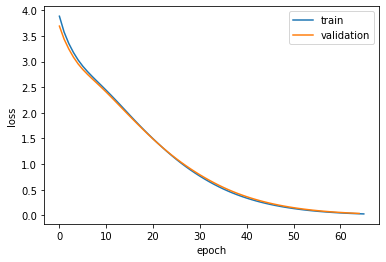

In [31]:

plt.figure()

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


In [32]:
eval_model = best_model
test_loss = evaluate(best_model, test_src, test_tgt)
print('=' * 89)
print('| End of training | test loss {:5.10f} | test ppl {:8.10f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

print("Last validation loss: {}".format(val_losses[-1]))

| End of training | test loss 0.0303687234 | test ppl 1.0308345567
Last validation loss: 0.038812208601634555


In [60]:
idx_to_letter = {val:key for key, val in char_nums.items()}

def batchify_for_seq_sampling(data):
    # get the length of each seq in your batch
    seq_lengths = torch.LongTensor([len(seq) for seq in data])
    train_vectorized = [[char_nums[char] for char in seq] for seq in data]

    # dump padding everywhere, and place seqs on the left.
    # NOTE: you only need a tensor as big as your longest sequence
    src_tensor = torch.zeros((len(train_vectorized), seq_lengths.max())).long()
    tgt_tensor = torch.zeros((len(train_vectorized), seq_lengths.max())).long()

    for idx, (seq, seqlen) in enumerate(zip(train_vectorized, seq_lengths)):
        src_tensor[idx, :(seqlen)] = torch.LongTensor(seq)

    return src_tensor, src_tensor


def sample_categorical(lnprobs, query, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome log-probabilities
    :param temperature: Sampling temperature. 1.0 follows the given distribution,
        0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """

    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature, dim=1)
    
    p[:,2] = torch.mean(p[:, :])*0.001*len(query)
    #print("softmaxed probs:", p)
    
    return dist.Categorical(p).sample()

def sample_sentence(model, query, max_len = 140, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while len(query) < max_len and '<eos>' not in query:
        data, targets = batchify_for_seq_sampling([query])
        data, targets = data.to(device), targets.to(device)
    
        src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
        tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
        tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))   
        
        output = output = eval_model(data, src_mask, targets, tgt_mask, src_pad_mask, tgt_pad_mask).view(-1, ntokens)
        
        next_char_idx = sample_categorical(output, query, temperature) #0.5
                
        try:
            query += [idx_to_letter[int(next_char_idx[-1])]]
        except IndexError:
            query += [idx_to_letter[int(next_char_idx)]]
            
    return query


In [61]:
import torch.distributions as dist
for _ in range(10):
    sample = sample_sentence(model, ["<sos>", "E"], max_len = 500, temperature=1.0)

    print(len(sample), " ".join(sample))
    

153 <sos> E E E Q W W W N N N N N N N N N N N N <sos> Q Q Q M C C K K T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T N N N N N N N N N N N N N N N N N N N A A F M H N N N N N N N <pad> G G G G G G G G G G G N N N N N N N N N N N N N N N N N N N N N N N N N N N <eos>
115 <sos> E E E E E E E E E E G G G G V V V V V V V V V V V V V V V V V V V V V V V H V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V <sos> Q Q Q Q Q H N N N N N N N N N N N Q P P A A D D D D D D D D D D D D D D H V V <eos>
198 <sos> E E E E E E E E E E E E A A A A A Q Q K K L L L L L L L L L L L P P P P P P P P P P P P P P P P P P P P P P P P P P P A A A A A A A <sos> <pad> <sos> M T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T <eos>


KeyboardInterrupt: 

[('in_proj_weight', torch.Size([360, 120])), ('in_proj_bias', torch.Size([360])), ('out_proj.weight', torch.Size([120, 120])), ('out_proj.bias', torch.Size([120])), ('weight', torch.Size([120, 120])), ('bias', torch.Size([120]))]


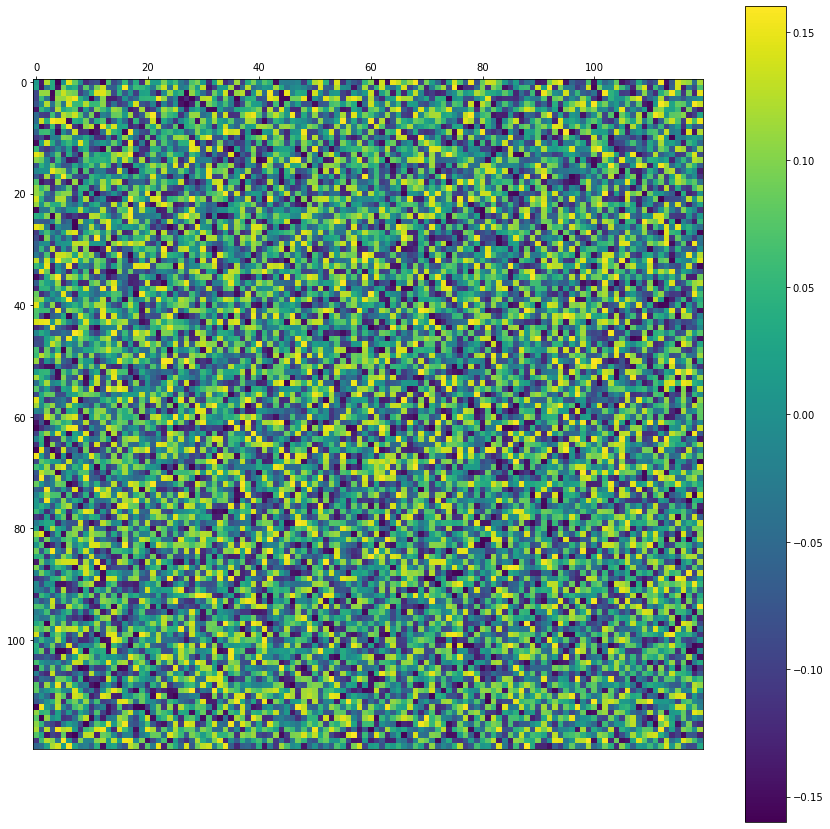

In [35]:
weights = []
for m in model.t_encoder.layers[0].self_attn.modules():
    
    for p in m.named_parameters():
        
        weights.append(p)
        
print([(w[0],w[1].shape) for w in weights])
w = weights[2][1]

fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(w.detach().cpu().numpy())
ax.xaxis.tick_top()
plt.colorbar()
plt.show()

<ipython-input-36-8c6ded218ed0>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.mul(F.softmax(torch.mul(q, torch.transpose(k,0,1))/8), v)


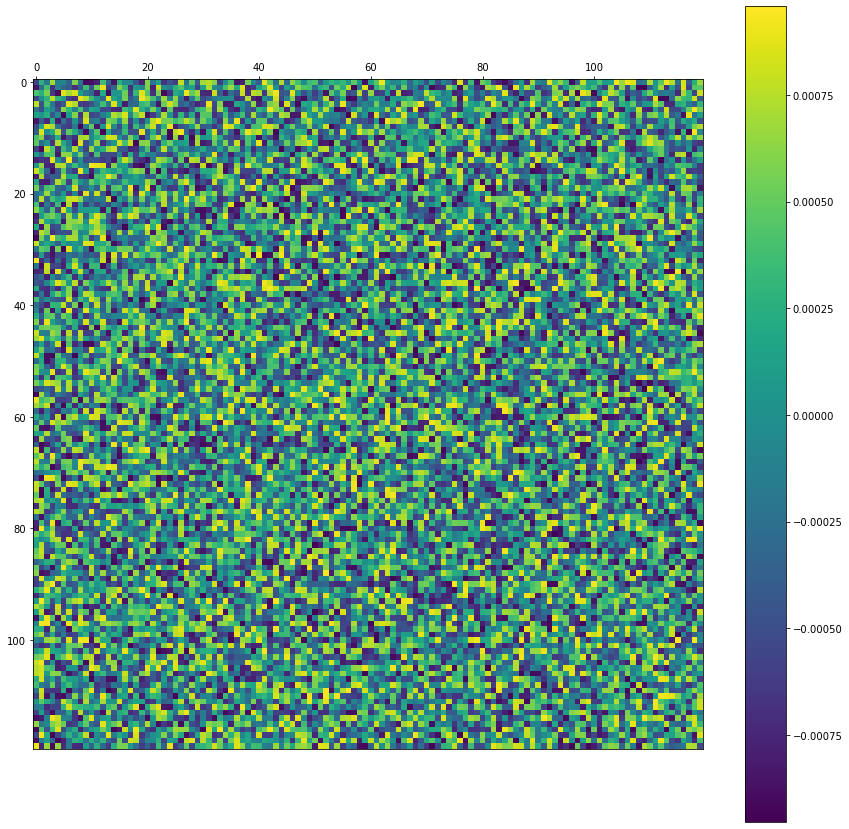

In [36]:
w = weights[0][1]
dim = int(w.shape[0] / 3)


w 
q = w[:dim]
k = w[dim : 2 * dim]
v = w[2 * dim :]


out = torch.mul(F.softmax(torch.mul(q, torch.transpose(k,0,1))/8), v)


fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(out.detach().cpu().numpy())

ax.xaxis.tick_top()
plt.colorbar()
plt.show()

In [65]:
#mod = TransformerModel(24, emsize, nhead, nhid, nlayers, dropout)

state_dict = torch.load("models/good_model.py")

In [81]:
weights = []

keys = []
for key in state_dict:
    
    if 'proj' in key and "out" in key and 'bias' not in key:
        print(key, state_dict[key])
        
        keys.append(key)
        
        weights.append(state_dict[key])

t_encoder.layers.0.self_attn.out_proj.weight tensor([[ 1.7944e-02,  1.0390e-02,  6.5664e-02,  ..., -3.8744e-02,
         -9.4107e-02,  2.2913e-02],
        [-2.2834e-02, -4.3931e-02,  9.7010e-02,  ...,  1.0247e-04,
         -1.4171e-04,  2.7677e-04],
        [-7.6942e-05, -6.9993e-02, -6.4399e-02,  ..., -3.3600e-05,
         -1.6496e-02,  1.1055e-04],
        ...,
        [-6.5633e-02, -1.1739e-02,  3.9774e-03,  ...,  7.3104e-04,
         -1.2584e-04, -5.2922e-02],
        [-6.4680e-02,  3.2277e-03,  5.5014e-02,  ...,  4.7047e-02,
          9.2505e-02,  5.2630e-02],
        [-4.4566e-02,  4.7641e-02, -5.1058e-02,  ...,  4.0434e-02,
          8.8700e-02, -4.4344e-02]], device='cuda:0')
t_encoder.layers.1.self_attn.out_proj.weight tensor([[-3.7507e-02,  9.5623e-02, -5.5000e-05,  ...,  2.9092e-02,
         -2.5238e-02, -1.6679e-03],
        [ 5.5117e-03,  8.0381e-02,  3.3657e-02,  ...,  8.7870e-02,
          1.4871e-02,  6.5918e-02],
        [ 9.6442e-03, -3.4738e-02,  4.0756e-02,  ...,  

In [84]:
keys

['t_encoder.layers.0.self_attn.out_proj.weight',
 't_encoder.layers.1.self_attn.out_proj.weight',
 't_encoder.layers.2.self_attn.out_proj.weight',
 't_encoder.layers.3.self_attn.out_proj.weight',
 't_encoder.layers.4.self_attn.out_proj.weight',
 't_encoder.layers.5.self_attn.out_proj.weight',
 't_decoder.layers.0.self_attn.out_proj.weight',
 't_decoder.layers.0.multihead_attn.out_proj.weight',
 't_decoder.layers.1.self_attn.out_proj.weight',
 't_decoder.layers.1.multihead_attn.out_proj.weight',
 't_decoder.layers.2.self_attn.out_proj.weight',
 't_decoder.layers.2.multihead_attn.out_proj.weight',
 't_decoder.layers.3.self_attn.out_proj.weight',
 't_decoder.layers.3.multihead_attn.out_proj.weight',
 't_decoder.layers.4.self_attn.out_proj.weight',
 't_decoder.layers.4.multihead_attn.out_proj.weight',
 't_decoder.layers.5.self_attn.out_proj.weight',
 't_decoder.layers.5.multihead_attn.out_proj.weight']

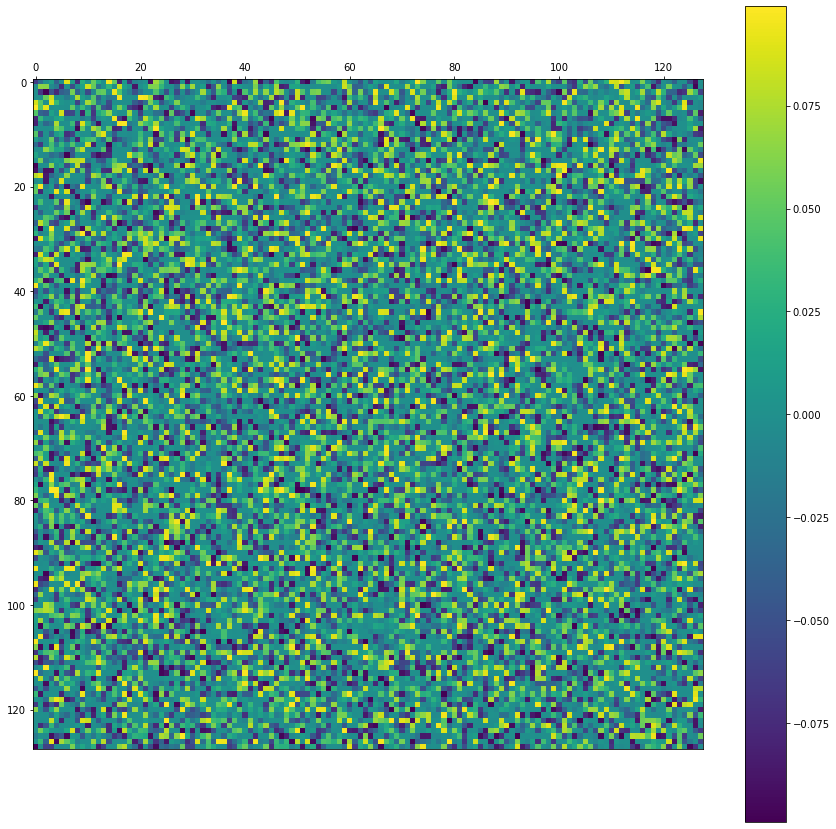

In [91]:
w = weights[-1]
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(w.detach().cpu().numpy())
ax.xaxis.tick_top()
plt.colorbar()
plt.show()